13 outlier(s) have been deleted.
The outlier(s) value(s) are : [242.5, 245.0, 265.0, 222.5, 260.0, 230.0, 240.0, 262.5, 252.5, 225.0, 267.5, 267.5, 232.5]
12 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
3 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
1 ectopic beat(s) have been deleted with malik rule.
13 outlier(s) have been deleted.
The outlier(s) value(s) are : [242.5, 245.0, 265.0, 222.5, 260.0, 230.0, 240.0, 262.5, 252.5, 225.0, 267.5, 267.5, 232.5]
16 ectopic beat(s) have been deleted with acar rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with acar rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with acar rule.


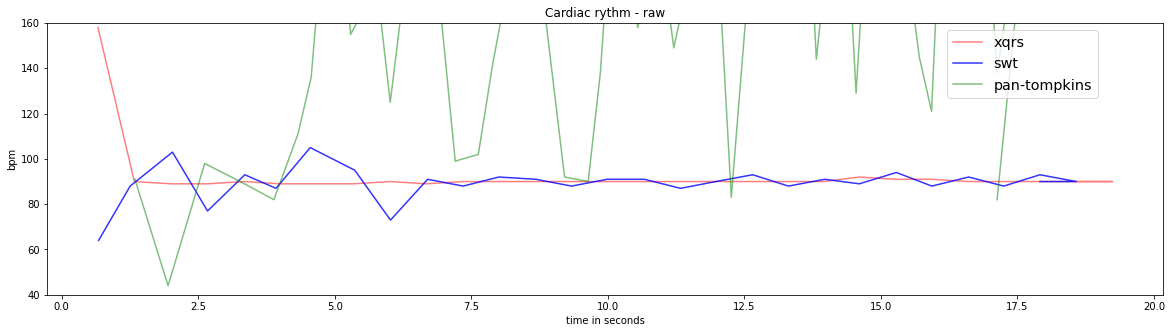

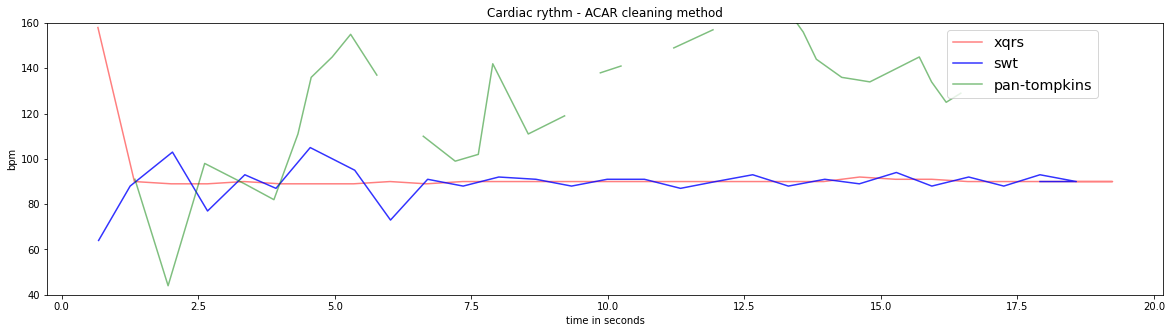

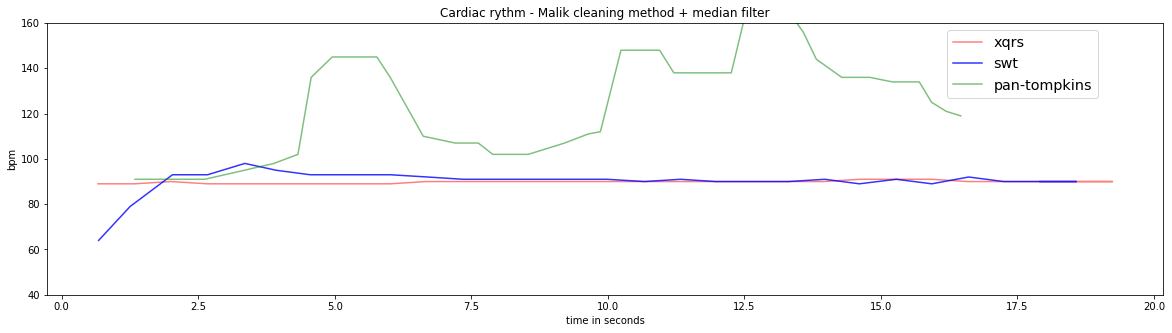

In [3]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np 
import math
import scipy.signal as signal
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values


def get_clean_intervals(rrs, method="malik"):
    # This remove outliers from signal
    rr_intervals_without_outliers = remove_outliers(rr_intervals=rrs,
                                                    low_rri=300, high_rri=1800)
    # This replace outliers nan values with linear interpolation
    interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,
                                                       interpolation_method="linear")

    # This remove ectopic beats from signal
    nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method=method)
    # This replace ectopic beats nan values with linear interpolation
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
    return interpolated_nn_intervals

def to_hr(rr_intervals):
    hr = np.zeros(len(rr_intervals))
    for i in range(0, len(rr_intervals)):
        if math.isnan(rr_intervals[i]):
            hr[i] = np.nan
        else:
            hr[i] = (int)(60 * 1000 / rr_intervals[i])

    return hr

ECG_FILE = "/home/zozi/Documents/Code/Projects/Epilepsy_Project/Aura/res-v0_4/dev/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t000.json"
ANNOTATIONS_FILE = "/home/zozi/Documents/Code/Projects/Epilepsy_Project/Aura/annot-v0_4/dev/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t000.json"

try:
    data = json.load(open(ECG_FILE, "r"))
    annotations = json.load(open(ANNOTATIONS_FILE, "r"))

    timestamps = {}
    timestamps["pan-tompkins"] = []
    timestamps["xqrs"] = []
    timestamps["swt"] = []

    for key in timestamps.keys():
        timestamps[key] = np.cumsum(data[key]["rr_intervals"][1:])
        timestamps[key] = np.append(timestamps[key], timestamps[key][-2])
        timestamps[key] *= 0.001


    clean_rr_intervals = {}
    clean_rr_intervals["pan-tompkins"] = get_clean_intervals(data["pan-tompkins"]["rr_intervals"])
    clean_rr_intervals["swt"] = get_clean_intervals(data["swt"]["rr_intervals"])
    clean_rr_intervals["xqrs"] = get_clean_intervals(data["xqrs"]["rr_intervals"])

    clean_hr = {}
    clean_hr["pan-tompkins"] = to_hr(clean_rr_intervals["pan-tompkins"])
    clean_hr["swt"] = to_hr(clean_rr_intervals["swt"])
    clean_hr["xqrs"] = to_hr(clean_rr_intervals["xqrs"])

    hr_median ={}
    hr_median["pan-tompkins"] = signal.medfilt(clean_hr["pan-tompkins"], 5)
    hr_median["swt"] = signal.medfilt(clean_hr["swt"], 5)
    hr_median["xqrs"] = signal.medfilt(clean_hr["xqrs"], 5)

    clean_rr_intervals_acar = {}
    clean_rr_intervals_acar["pan-tompkins"] = get_clean_intervals(data["pan-tompkins"]["rr_intervals"], method="acar")
    clean_rr_intervals_acar["swt"] = get_clean_intervals(data["swt"]["rr_intervals"], method="acar")
    clean_rr_intervals_acar["xqrs"] = get_clean_intervals(data["xqrs"]["rr_intervals"], method="acar")

    clean_hr_acar = {}
    clean_hr_acar["pan-tompkins"] = to_hr(clean_rr_intervals_acar["pan-tompkins"])
    clean_hr_acar["swt"] = to_hr(clean_rr_intervals_acar["swt"])
    clean_hr_acar["xqrs"] = to_hr(clean_rr_intervals_acar["xqrs"])
    
    #Raw RR intervals
    plt.figure(1, figsize = (20,5))
    plt.ylim((40, 160))
    plt.title("Cardiac rythm - raw")
    plt.xlabel("time in seconds")
    plt.ylabel("bpm")
    plt.plot(timestamps["xqrs"], data["xqrs"]["hr"], color='red', alpha=0.5, label="xqrs")
    plt.plot(timestamps["swt"], data["swt"]["hr"], color='blue', alpha=0.8, label="swt")
    plt.plot(timestamps["pan-tompkins"], data["pan-tompkins"]["hr"],  color='green', alpha=0.5, label="pan-tompkins")
    for seizure in annotations["seizure"]:
        plt.axvspan(seizure[0], seizure[1], facecolor='grey', alpha=0.5)
    plt.legend(bbox_to_anchor=(0.80, 1), loc='upper left', fontsize='x-large')
    plt.show()

    # Clean  RR intervals with Acar method
    plt.figure(1, figsize = (20,5))
    plt.ylim((40, 160))
    plt.title("Cardiac rythm - ACAR cleaning method")
    plt.xlabel("time in seconds")
    plt.ylabel("bpm")
    plt.plot(timestamps["xqrs"], clean_hr_acar["xqrs"], color='red', alpha=0.5, label="xqrs")
    plt.plot(timestamps["swt"], clean_hr_acar["swt"], color='blue', alpha=0.8, label="swt")
    plt.plot(timestamps["pan-tompkins"], clean_hr_acar["pan-tompkins"], color='green', alpha=0.5, label="pan-tompkins")
    for seizure in annotations["seizure"]:
        plt.axvspan(seizure[0], seizure[1], facecolor='grey', alpha=0.5)
    plt.legend(bbox_to_anchor=(0.80, 1), loc='upper left', fontsize='x-large')
    plt.show()
    
    # Clean RR intervals with Malik + median filter
    plt.figure(1, figsize = (20,5))
    plt.ylim((40, 160))
    plt.title("Cardiac rythm - Malik cleaning method + median filter")
    plt.xlabel("time in seconds")
    plt.ylabel("bpm")
    plt.plot(timestamps["xqrs"], hr_median["xqrs"], color='red', alpha=0.5, label="xqrs")
    plt.plot(timestamps["swt"], hr_median["swt"], color='blue', alpha=0.8, label="swt")
    plt.plot(timestamps["pan-tompkins"], hr_median["pan-tompkins"], color='green', alpha=0.5, label="pan-tompkins")

    for seizure in annotations["seizure"]:
        plt.axvspan(seizure[0], seizure[1], facecolor='grey', alpha=0.5)
    plt.legend(bbox_to_anchor=(0.80, 1), loc='upper left', fontsize='x-large')
    plt.show()
except Exception as e:
    print(e)
    print("Error")
        
    
    

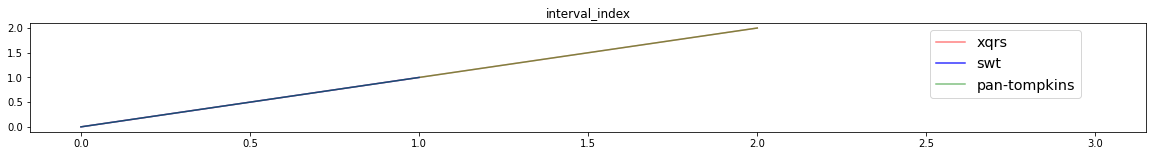

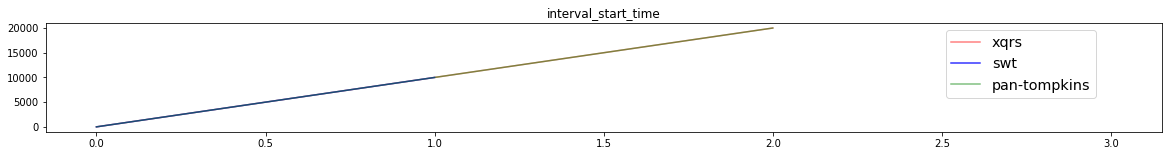

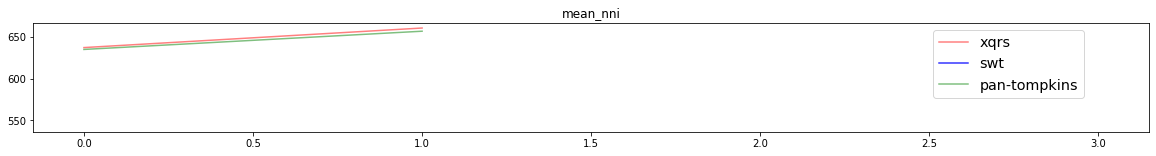

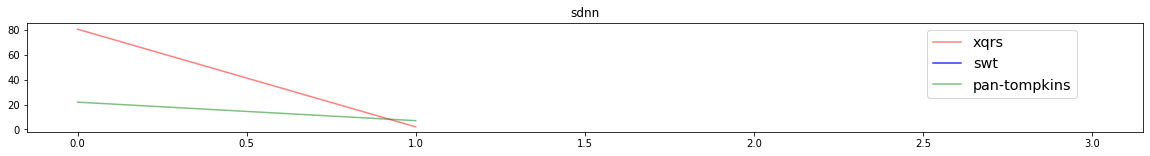

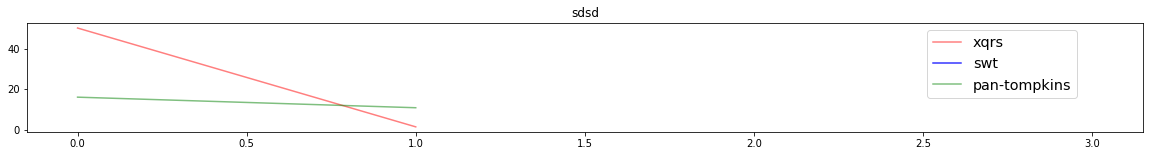

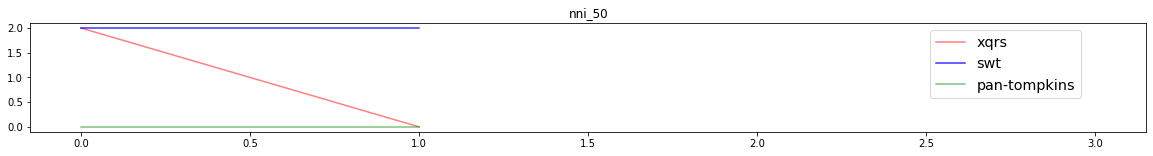

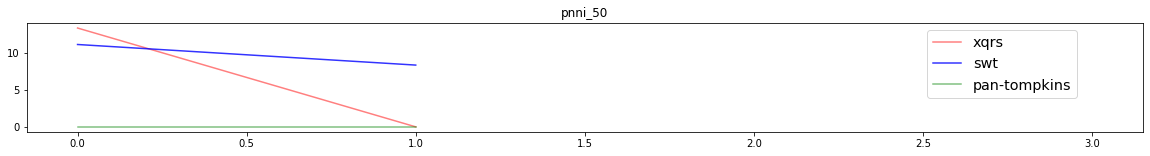

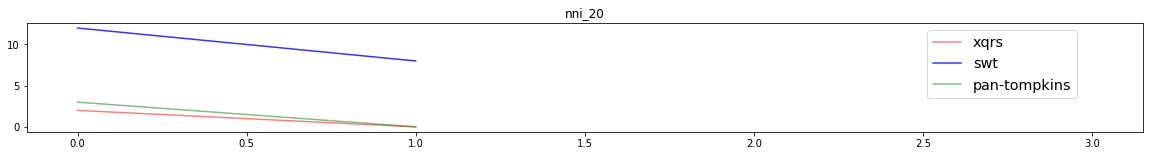

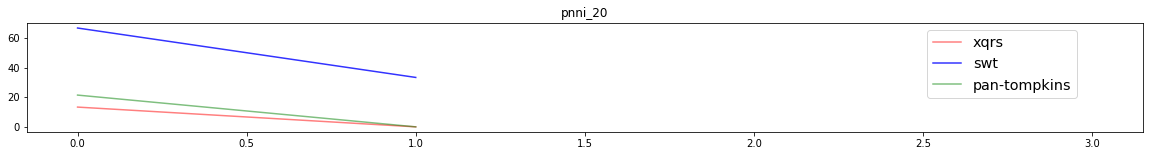

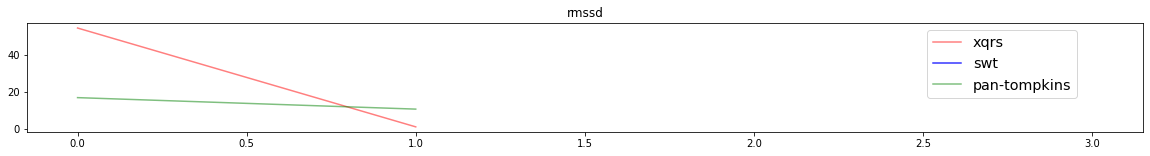

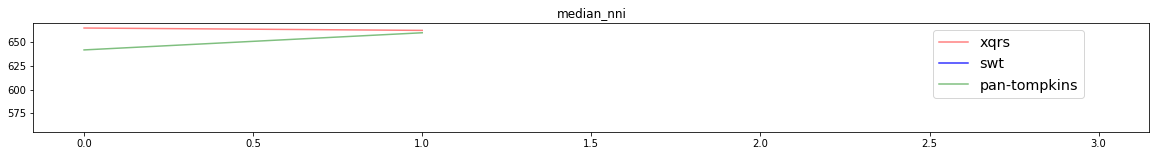

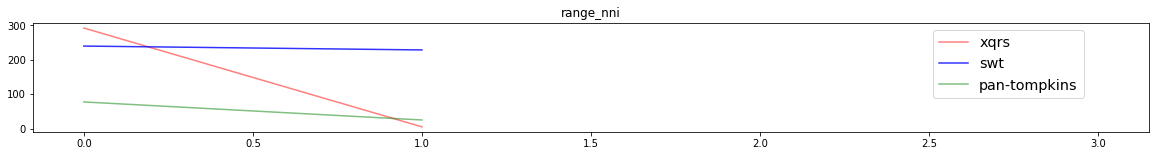

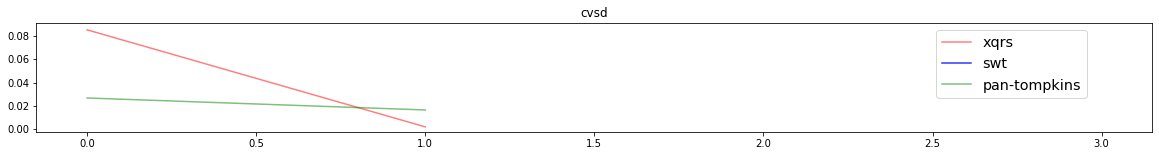

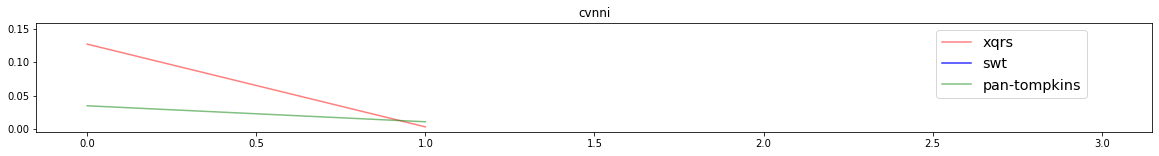

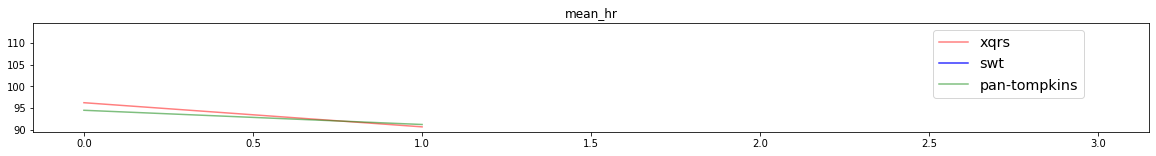

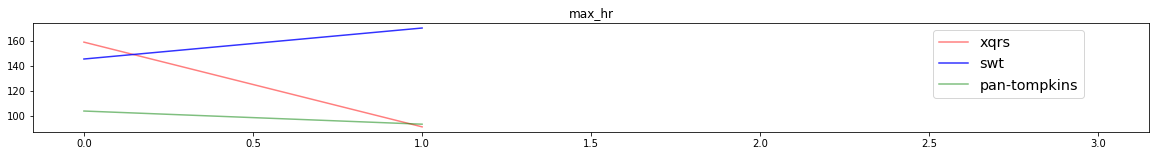

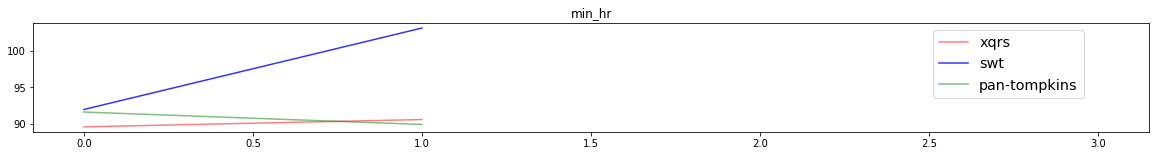

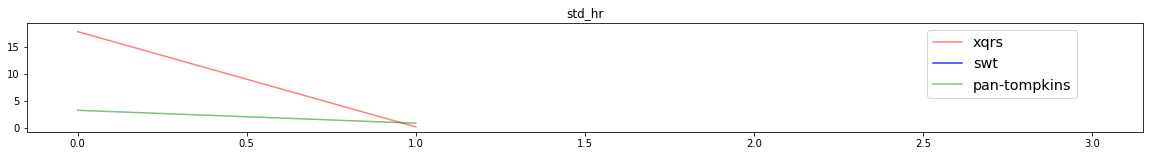

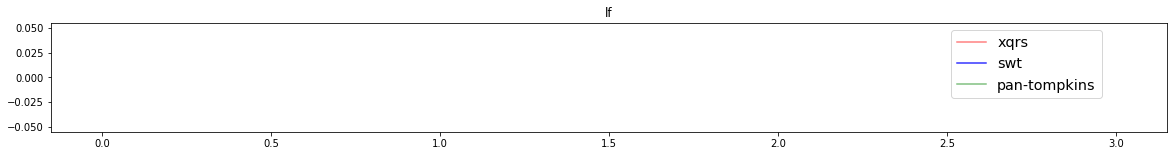

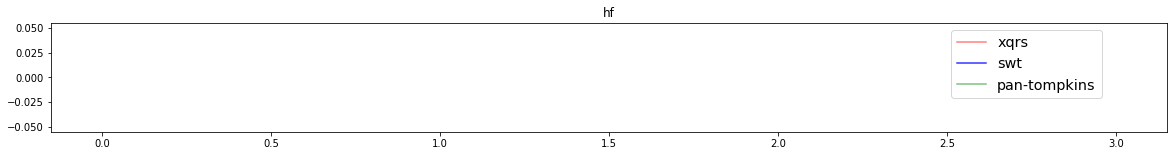

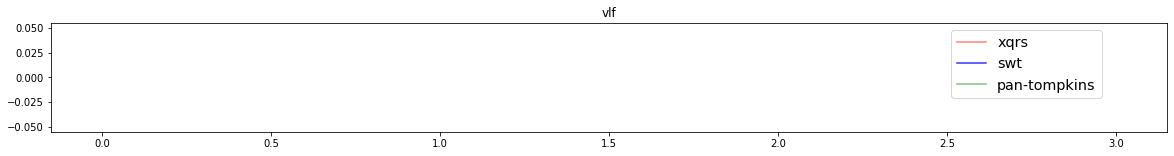

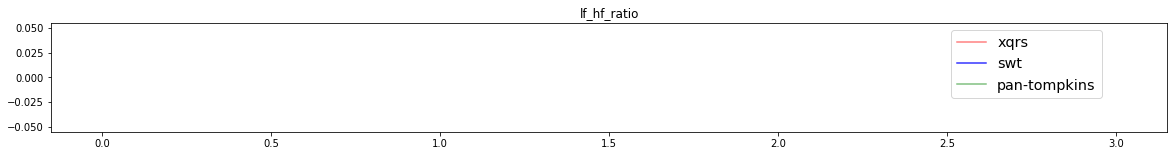

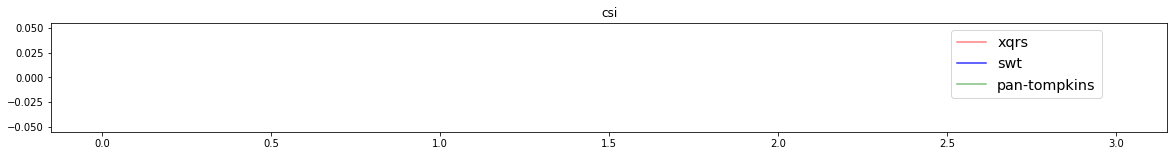

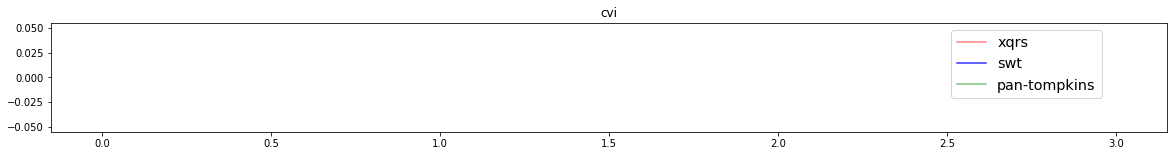

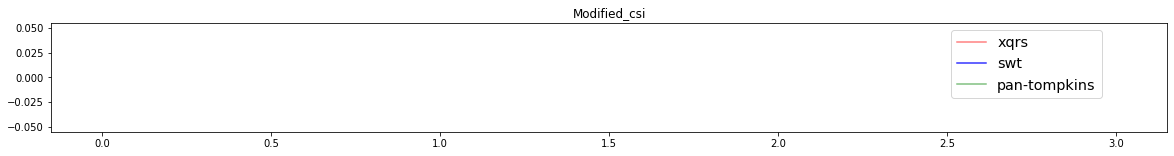

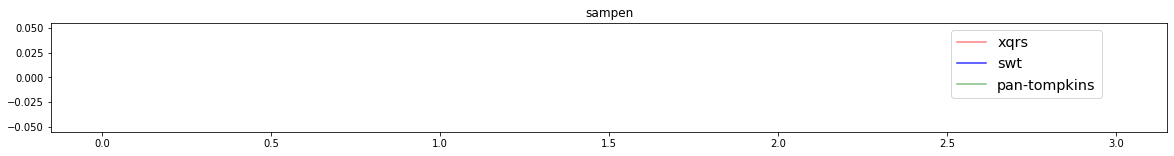

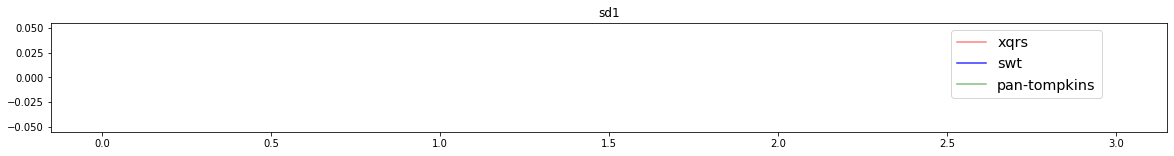

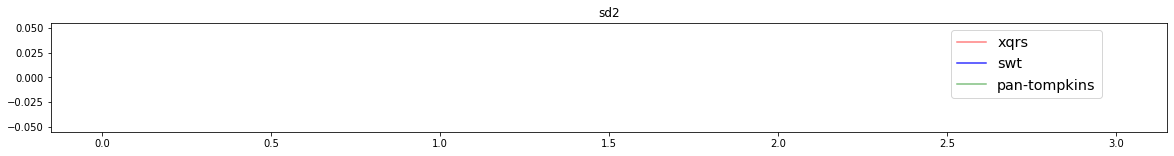

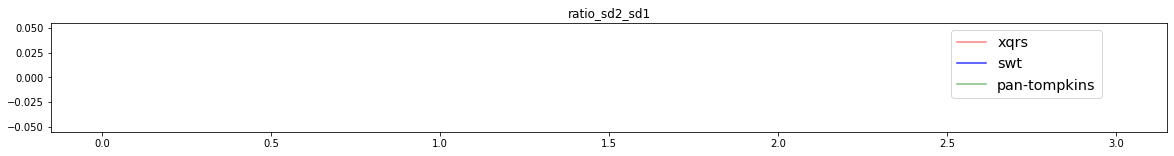

In [4]:
XQRS_FEATS_FILE = "/home/zozi/Documents/Code/Projects/Epilepsy_Project/Aura/feats-v0_4/dev/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t000-xqrs.json"
PAN_TOMPKINS_FEATS_FILE = "/home/zozi/Documents/Code/Projects/Epilepsy_Project/Aura/feats-v0_4/dev/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t000-pan.json"
SWT_FILE = "/home/zozi/Documents/Code/Projects/Epilepsy_Project/Aura/feats-v0_4/dev/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t000-swt.json"

xqrs_data = json.load(open(XQRS_FEATS_FILE, "r"))
panTompkins_data = json.load(open(PAN_TOMPKINS_FEATS_FILE, "r"))
swt_data = json.load(open(SWT_FILE, "r"))

xqrs_features = np.array(xqrs_data["features"])
panTompkins_features = np.array(panTompkins_data["features"])
swt_features = np.array(swt_data["features"])

xqrs_features_tp = np.transpose(xqrs_features)
panTompkins_features_tp = np.transpose(panTompkins_features)
swt_features_tp =np.transpose(swt_features)

for i in range(0, len(xqrs_data["keys"][:-1])):
    plt.figure(1, figsize = (20,2))
    #print(xqrs_data["keys"][i])
    plt.title(xqrs_data["keys"][i])
    plt.plot(xqrs_features_tp[i], color='red', alpha=0.5, label="xqrs")
    plt.plot(panTompkins_features_tp[i], color='blue', alpha=0.8, label="swt")
    plt.plot(swt_features_tp[i], color='green', alpha=0.5, label="pan-tompkins")
    plt.legend(bbox_to_anchor=(0.80, 1), loc='upper left', fontsize='x-large')
    
    for j in range(0, len(xqrs_features_tp[29])):
        plt.axvspan(j, (j + 1), facecolor='grey', alpha=0.5 * xqrs_features_tp[29][j])
    plt.plot()
    plt.show()

In [7]:
XQRS_FEATS_FILE = "/home/zozi/Documents/Code/Projects/Epilepsy_Project/Aura/feats-v0_4/dev/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t000-xqrs.json"
PAN_TOMPKINS_FEATS_FILE = "/home/zozi/Documents/Code/Projects/Epilepsy_Project/Aura/feats-v0_4/dev/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t000-pan.json"
SWT_FILE = "/home/zozi/Documents/Code/Projects/Epilepsy_Project/Aura/feats-v0_4/dev/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t000-swt.json"

xqrs_data = json.load(open(XQRS_FEATS_FILE, "r"))
panTompkins_data = json.load(open(PAN_TOMPKINS_FEATS_FILE, "r"))
swt_data = json.load(open(SWT_FILE, "r"))

In [8]:
import pandas as pd

In [12]:
len(np.array(swt_data['features']).T)

30

In [13]:
len(swt_data['keys'])

30

In [16]:
swt_data['keys']

['interval_index',
 'interval_start_time',
 'mean_nni',
 'sdnn',
 'sdsd',
 'nni_50',
 'pnni_50',
 'nni_20',
 'pnni_20',
 'rmssd',
 'median_nni',
 'range_nni',
 'cvsd',
 'cvnni',
 'mean_hr',
 'max_hr',
 'min_hr',
 'std_hr',
 'lf',
 'hf',
 'vlf',
 'lf_hf_ratio',
 'csi',
 'cvi',
 'Modified_csi',
 'sampen',
 'sd1',
 'sd2',
 'ratio_sd2_sd1',
 'label']

In [18]:
np.array(swt_data['features'])

array([[0.00000000e+00, 0.00000000e+00, 6.35267857e+02, 2.20204154e+01,
        1.60798442e+01, 0.00000000e+00, 0.00000000e+00, 3.00000000e+00,
        2.14285714e+01, 1.70195024e+01, 6.41875000e+02, 7.75000000e+01,
        2.67910649e-02, 3.46631978e-02, 9.45595437e+01, 1.03896104e+02,
        9.16030534e+01, 3.33123324e+00,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+04, 6.57166667e+02, 7.06264486e+00,
        1.08326792e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.08562030e+01, 6.60000000e+02, 2.50000000e+01,
        1.65197103e-02, 1.07471137e-02, 9.13109125e+01, 9.33852140e+01,
        8.98876404e+01, 9.50948856e-01,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,

In [21]:
pd_swt = pd.DataFrame(columns = swt_data['keys'], data = swt_data['features'])

In [22]:
pd_swt.head()

,interval_index,interval_start_time,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,...,vlf,lf_hf_ratio,csi,cvi,Modified_csi,sampen,sd1,sd2,ratio_sd2_sd1,label
0,0.0,0.0,635.267857,22.020415,16.079844,0.0,0.0,3.0,21.428571,17.019502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1.0,10000.0,657.166667,7.062645,10.832679,0.0,0.0,0.0,0.000000,10.856203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2.0,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def load_data(path):
    data = json.load(open(path, "r"))
    df = pd.DataFrame(columns = data['keys'], data = data['features'])
    return df

In [24]:
df_2 = load_data(SWT_FILE)

In [25]:
df_2.head()

,interval_index,interval_start_time,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,...,vlf,lf_hf_ratio,csi,cvi,Modified_csi,sampen,sd1,sd2,ratio_sd2_sd1,label
0,0.0,0.0,635.267857,22.020415,16.079844,0.0,0.0,3.0,21.428571,17.019502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1.0,10000.0,657.166667,7.062645,10.832679,0.0,0.0,0.0,0.000000,10.856203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2.0,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
load_data(ECG_FILE).head()

KeyError: 'keys'

In [27]:
data = json.load(open(ECG_FILE, "r"))

In [30]:
data.keys()

dict_keys(['infos', 'pan-tompkins', 'swt', 'xqrs', 'score'])

In [32]:
data.values()

dict_values([{'sampling_freq': 400, 'start_datetime': '2003-07-21T17:12:54', 'exam_duration': 20, 'ref_file': '00000258_s002_t000.edf'}, {'qrs': [294, 555, 1092, 1335, 1603, 1895, 2110, 2286, 2383, 2537, 2672, 2864, 2962, 3204, 3438, 3607, 3713, 3973, 4239, 4412, 4501, 4652, 4774, 4935, 5039, 5326, 5460, 5588, 5729, 5821, 5987, 6083, 6269, 6374, 6475, 6640, 6837, 6927, 7034, 7141, 7314, 7407, 7699], 'rr_intervals': [652.5, 1342.5, 607.5, 670.0, 730.0, 537.5, 440.0, 242.5, 385.0, 337.5, 480.0, 245.0, 605.0, 585.0, 422.5, 265.0, 650.0, 665.0, 432.5, 222.5, 377.5, 305.0, 402.5, 260.0, 717.5, 335.0, 320.0, 352.5, 230.0, 415.0, 240.0, 465.0, 262.5, 252.5, 412.5, 492.5, 225.0, 267.5, 267.5, 432.5, 232.5, 730.0], 'hr': [91.0, 44.0, 98.0, 89.0, 82.0, 111.0, 136.0, 247.0, 155.0, 177.0, 125.0, 244.0, 99.0, 102.0, 142.0, 226.0, 92.0, 90.0, 138.0, 269.0, 158.0, 196.0, 149.0, 230.0, 83.0, 179.0, 187.0, 170.0, 260.0, 144.0, 250.0, 129.0, 228.0, 237.0, 145.0, 121.0, 266.0, 224.0, 224.0, 138.0, 258.0,

In [34]:
for key in list(data.keys()):
    print(len(data[key]))

4
3
3
3
3


In [95]:
def load_data_res(path, features):
    '''
    features peut prendre la valeur pan-tompkins, swt, ou xqrs
    '''
    data = json.load(open(path, "r"))
    df = pd.DataFrame(columns = list(data[features]), data = list(map(list, zip(*list(data[features].values())))))
    return df

In [100]:
load_data_res(ECG_FILE, 'xqrs')

,qrs,rr_intervals,hr
0,124,377.5,158.0
1,275,665.0,90.0
2,541,667.5,89.0
3,808,672.5,89.0
4,1077,665.0,90.0
5,1343,670.0,89.0
6,1611,667.5,89.0
7,1878,672.5,89.0
8,2147,665.0,90.0
9,2413,670.0,89.0


In [44]:
data.keys()

dict_keys(['infos', 'pan-tompkins', 'swt', 'xqrs', 'score'])

In [47]:
list(data['swt'])

['qrs', 'rr_intervals', 'hr']

In [92]:
list(map(list, zip(*list(data['swt'].values()))))

[[170, 937.5, 64.0],
 [545, 677.5, 88.0],
 [816, 577.5, 103.0],
 [1047, 775.0, 77.0],
 [1357, 642.5, 93.0],
 [1614, 682.5, 87.0],
 [1887, 570.0, 105.0],
 [2115, 627.5, 95.0],
 [2366, 815.0, 73.0],
 [2692, 655.0, 91.0],
 [2954, 680.0, 88.0],
 [3226, 650.0, 92.0],
 [3486, 652.5, 91.0],
 [3747, 680.0, 88.0],
 [4019, 652.5, 91.0],
 [4280, 652.5, 91.0],
 [4541, 682.5, 87.0],
 [4814, 660.0, 90.0],
 [5078, 645.0, 93.0],
 [5336, 677.5, 88.0],
 [5607, 652.5, 91.0],
 [5868, 667.5, 89.0],
 [6135, 632.5, 94.0],
 [6388, 677.5, 88.0],
 [6659, 650.0, 92.0],
 [6919, 675.0, 88.0],
 [7189, 642.5, 93.0],
 [7446, 662.5, 90.0],
 [7711, 665.0, 90.0]]

[[170,
  545,
  816,
  1047,
  1357,
  1614,
  1887,
  2115,
  2366,
  2692,
  2954,
  3226,
  3486,
  3747,
  4019,
  4280,
  4541,
  4814,
  5078,
  5336,
  5607,
  5868,
  6135,
  6388,
  6659,
  6919,
  7189,
  7446,
  7711,
  7977],
 [937.5,
  677.5,
  577.5,
  775.0,
  642.5,
  682.5,
  570.0,
  627.5,
  815.0,
  655.0,
  680.0,
  650.0,
  652.5,
  680.0,
  652.5,
  652.5,
  682.5,
  660.0,
  645.0,
  677.5,
  652.5,
  667.5,
  632.5,
  677.5,
  650.0,
  675.0,
  642.5,
  662.5,
  665.0],
 [64.0,
  88.0,
  103.0,
  77.0,
  93.0,
  87.0,
  105.0,
  95.0,
  73.0,
  91.0,
  88.0,
  92.0,
  91.0,
  88.0,
  91.0,
  91.0,
  87.0,
  90.0,
  93.0,
  88.0,
  91.0,
  89.0,
  94.0,
  88.0,
  92.0,
  88.0,
  93.0,
  90.0,
  90.0]]

In [89]:
list((np.array(data['swt'].values()).T).item())

[[170,
  545,
  816,
  1047,
  1357,
  1614,
  1887,
  2115,
  2366,
  2692,
  2954,
  3226,
  3486,
  3747,
  4019,
  4280,
  4541,
  4814,
  5078,
  5336,
  5607,
  5868,
  6135,
  6388,
  6659,
  6919,
  7189,
  7446,
  7711,
  7977],
 [937.5,
  677.5,
  577.5,
  775.0,
  642.5,
  682.5,
  570.0,
  627.5,
  815.0,
  655.0,
  680.0,
  650.0,
  652.5,
  680.0,
  652.5,
  652.5,
  682.5,
  660.0,
  645.0,
  677.5,
  652.5,
  667.5,
  632.5,
  677.5,
  650.0,
  675.0,
  642.5,
  662.5,
  665.0],
 [64.0,
  88.0,
  103.0,
  77.0,
  93.0,
  87.0,
  105.0,
  95.0,
  73.0,
  91.0,
  88.0,
  92.0,
  91.0,
  88.0,
  91.0,
  91.0,
  87.0,
  90.0,
  93.0,
  88.0,
  91.0,
  89.0,
  94.0,
  88.0,
  92.0,
  88.0,
  93.0,
  90.0,
  90.0]]